<a href="https://colab.research.google.com/github/sinaschack/MolProt-Affinity-Drug-Discovery-Predictive-Modeling-Pipeline/blob/main/MolProt_Affinity_An_End%E2%80%91to%E2%80%91End%2C_Explainable_Multi%E2%80%91Modal_Drug%E2%80%93Target_Affinity_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install chembl-webresource-client

  Using cached chembl_webresource_client-0.10.9-py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.6 MB/s eta 0:00:00


In [10]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np

def fetch_chembl_data(target_chembl_id, output_csv):
    activity = new_client.activity
    print(f"Fetching IC50 data for target: {target_chembl_id}")

    # Query ChEMBL API
    results = activity.filter(
        target_chembl_id=target_chembl_id,
        standard_type="IC50"
    )

    # Take only first 500 entries
    results = list(results)[:500]

    # Collect valid rows
    data = []
    for r in results:
        smiles = r.get("canonical_smiles")
        ic50 = r.get("standard_value")
        if smiles and ic50:
            data.append([smiles, ic50])

    # Build DataFrame
    df = pd.DataFrame(data, columns=["smiles", "IC50_nM"])
    df["IC50_nM"] = pd.to_numeric(df["IC50_nM"], errors="coerce")
    df = df[df["IC50_nM"] > 0]

    # Convert IC50 → pIC50
    df["pIC50"] = 9 - np.log10(df["IC50_nM"])

    # Save CSV
    df.to_csv(output_csv, index=False)
    print(f"Saved dataset: {output_csv}")
    print(f"Rows collected: {len(df)}")

    return df

# Example usage
df = fetch_chembl_data("CHEMBL203", "chembl_egfr.csv")
df.head()

Fetching IC50 data for target: CHEMBL203
Saved dataset: chembl_egfr.csv
Rows collected: 479


,smiles,IC50_nM,pIC50
0,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,41.0,7.387216
1,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,300.0,6.522879
2,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7820.0,5.106793
3,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,170.0,6.769551
4,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,40.0,7.397940


In [2]:
from google.colab import drive
!rm -rf /content/drive  # remove old folder if needed
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!mkdir -p "/content/drive/My Drive/molprot-affinity/data/raw"

In [26]:
#Save data
!cp /content/chembl_egfr.csv "/content/drive/My Drive/molprot-affinity/data/raw/"
!ls "/content/drive/My Drive/molprot-affinity/data/raw/"

# Data Cleaning & Exploration

Null values per column:
 smiles     0
IC50_nM    0
pIC50      0
dtype: int64
pIC50 value range: 2.1870866433571443 to 11.221848749616356
(365, 3)


,smiles,IC50_nM,pIC50
0,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,41.0,7.387216
3,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,170.0,6.769551
6,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,9300.0,5.031517
7,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,500000.0,3.301030
8,O=C(O)/C=C/c1ccc(O)cc1,3000000.0,2.522879


pIC50 statistics:
count    365.000000
mean       5.914501
std        2.022811
min        2.187087
25%        4.000000
50%        5.494850
75%        7.619789
max       11.221849
Name: pIC50, dtype: float64


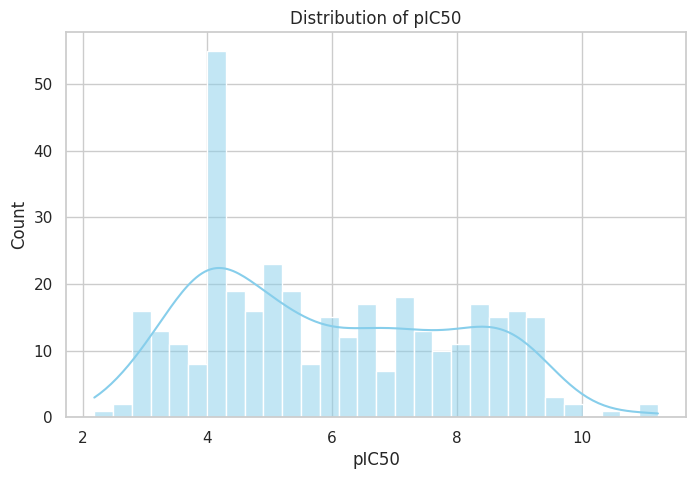

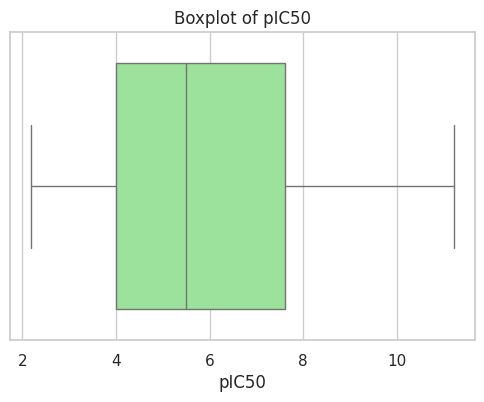

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (replace path if needed)
csv_path = "/content/drive/My Drive/molprot-affinity/data/raw/chembl_egfr.csv"
df = pd.read_csv(csv_path)

# Remove duplicates if any
df = df.drop_duplicates(subset=['smiles'])

# Check for null/NaN or unexpected values
print("Null values per column:\n", df.isnull().sum())
print("pIC50 value range:", df["pIC50"].min(), "to", df["pIC50"].max())

# Check df
print(df.shape)
display(df.head())

# Basic stats
print("pIC50 statistics:")
print(df['pIC50'].describe())

# --------- Explore pIC50 distribution with a histogram/boxplot ---------

# Set plot style
sns.set(style="whitegrid")

# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df['pIC50'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of pIC50")
plt.xlabel("pIC50")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=df['pIC50'], color='lightgreen')
plt.title("Boxplot of pIC50")
plt.xlabel("pIC50")
plt.show()


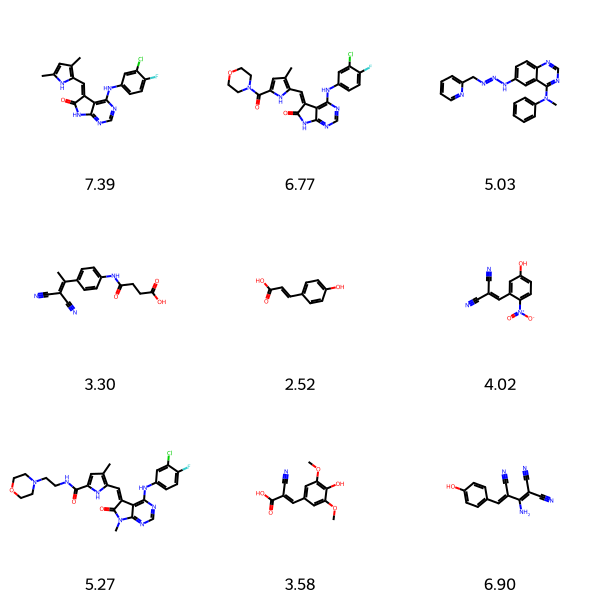

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Convert first 9 SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(s) for s in df['smiles'][:9]]

# Titles: pIC50 values
titles = [f"{pIC:.2f}" for pIC in df['pIC50'][:9]]

# Draw 3x3 grid with titles
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=titles)
display(img)

Top 10 most potent molecules:
                                 smiles  pIC50
0          CCOc1ccc2nc(SCc3ccccc3)sc2c1   7.39
1       CC(C)Oc1ccc2nc(SCc3ccccc3)sc2c1   6.77
6  CCN(CC)CCOc1ccc2nc(SCc3ccccc3)sc2c1C   6.10
7          COc1ccc2nc(SCc3ccccc3)sc2c1C   5.50
2   CCN(CC)CCOc1ccc2nc(SCc3ccccc3)sc2c1   5.03
8        CCOc1ccc2nc(SCc3ccccc3)sc2c1CC   4.80
5      CC(C)Oc1ccc2nc(SCc3ccccc3)sc2c1C   4.02
3           COc1ccc2nc(SCc3ccccc3)sc2c1   3.30
4         CCOc1ccc2nc(SCc3ccccc3)sc2c1C   2.52

Potency-colored molecule grid (green = strong, red = weak):


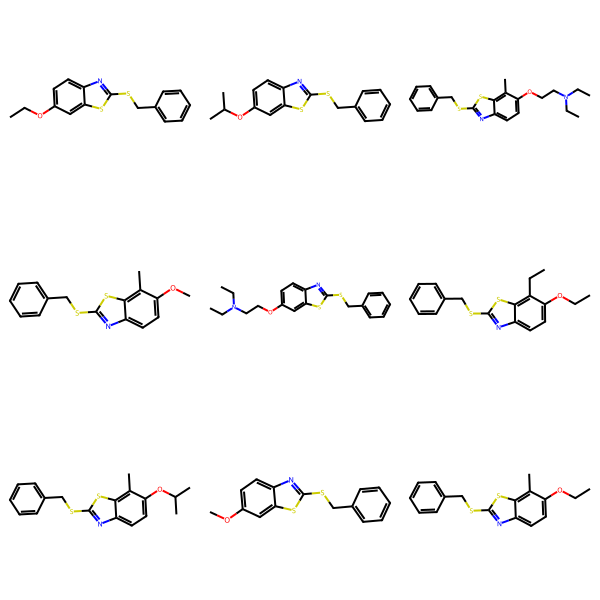

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import matplotlib
from IPython.display import display
import pandas as pd

# Sort by potency (highest pIC50 first) and print top 10
df_sorted = df.sort_values('pIC50', ascending=False)
print("Top 10 most potent molecules:")
print(df_sorted[['smiles', 'pIC50']].head(10))

# Select top 9 molecules for the 3x3 grid
mols = [Chem.MolFromSmiles(s) for s in df_sorted['smiles'][:9]]
pICs = df_sorted['pIC50'][:9].values

# Normalize pIC50 across the full dataset for color mapping
norm = matplotlib.colors.Normalize(vmin=df['pIC50'].min(), vmax=df['pIC50'].max())
cmap = matplotlib.colormaps['RdYlGn']  # green = high potency, red = low

# Render molecules and tint backgrounds by potency
imgs = []
for mol, pIC in zip(mols, pICs):
    color = tuple(int(c*255) for c in cmap(norm(pIC))[:3])  # RGB
    mol_img = Draw.MolToImage(mol, size=(200, 200))
    bg = Image.new("RGB", mol_img.size, color)
    bg.paste(mol_img, (0, 0), mol_img.convert("RGBA"))
    imgs.append(bg)

# Combine images into a 3x3 grid
rows, cols = 3, 3
grid = Image.new("RGB", (cols*200, rows*200), (255, 255, 255))
for i, img in enumerate(imgs):
    x = (i % cols) * 200
    y = (i // cols) * 200
    grid.paste(img, (x, y))

# Display the potency-colored molecule grid
print("\nPotency-colored molecule grid (green = strong, red = weak):")
display(grid)

# Feature Engineering

In [8]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 36.8 MB/s eta 0:00:00


In [29]:
import numpy as np
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Descriptors

# -------------------------------------------------------
# 1. Load your dataset
# -------------------------------------------------------
csv_path = "/content/drive/My Drive/molprot-affinity/data/raw/chembl_egfr.csv"
df = pd.read_csv(csv_path)

# Remove invalid or duplicate SMILES
df = df.drop_duplicates(subset=['smiles']).reset_index(drop=True)

# -------------------------------------------------------
# 2. Morgan Fingerprints
# -------------------------------------------------------
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

def smiles_to_morgan(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return list(morgan_gen.GetFingerprint(mol))

df['morgan_fp'] = df['smiles'].apply(smiles_to_morgan)

# Remove SMILES that failed to generate fingerprints
df = df[df['morgan_fp'].notnull()].reset_index(drop=True)

# Convert fingerprints to numpy matrix (N × 1024)
X = np.array(df['morgan_fp'].tolist())
y = df['pIC50'].values

# -------------------------------------------------------
# 3. RDKit molecular descriptors
# -------------------------------------------------------
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol)
    ]

desc_list = df['smiles'].apply(compute_descriptors)
desc_array = np.array(desc_list.tolist())     # Shape: (N × 6)

# -------------------------------------------------------
# 4. Combine Morgan + RDKit features
# -------------------------------------------------------
X_combined = np.hstack([X, desc_array])       # Shape: (N × 1030)

# -------------------------------------------------------
# 5. Save Pickles
# -------------------------------------------------------
!mkdir -p "/content/drive/My Drive/molprot-affinity/data/pickle"

# Save Morgan-only
with open("/content/drive/My Drive/molprot-affinity/data/pickle/egfr_morgan.pkl", "wb") as f:
    pickle.dump({'X': X, 'y': y, 'smiles': df['smiles'].tolist()}, f)

# Save Morgan + Descriptors combined
with open("/content/drive/My Drive/molprot-affinity/data/pickle/egfr_morgan_rdkit.pkl", "wb") as f:
    pickle.dump({'X': X_combined, 'y': y, 'smiles': df['smiles'].tolist()}, f)

print("Saved:")
print(" - egfr_morgan.pkl  (Morgan fingerprints)")
print(" - egfr_morgan_rdkit.pkl  (Morgan + RDKit descriptors)")
print("Combined feature matrix shape:", X_combined.shape)

Saved:
 - egfr_morgan.pkl  (Morgan fingerprints)
 - egfr_morgan_rdkit.pkl  (Morgan + RDKit descriptors)
Combined feature matrix shape: (365, 1030)


In [36]:
import numpy as np
import pandas as pd
from collections import Counter
import itertools
import requests

# 1. Load EGFR sequence from UniProt ----------------------------
url = "https://rest.uniprot.org/uniprotkb/P00533.fasta"
fasta = requests.get(url).text
egfr_seq = "".join([line.strip() for line in fasta.split("\n") if not line.startswith(">")])

# 2. Protein feature functions ----------------------------------

# AA composition (20-dimensional)
def aa_composition(seq):
    aa = "ACDEFGHIKLMNPQRSTVWY"
    counts = Counter(seq)
    total = len(seq)
    return np.array([counts[a] / total for a in aa])

# 2-mer composition (400-dimensional)
def kmer_counts(seq, k=2):
    kmers = [''.join(p) for p in itertools.product("ACDEFGHIKLMNPQRSTVWY", repeat=k)]
    counter = Counter(seq[i:i+k] for i in range(len(seq)-k+1))
    total = len(seq) - k + 1
    return np.array([counter[km] / total for km in kmers])

# 3. Compute protein features ------------------------------------
X_aa = aa_composition(egfr_seq)
X_kmer = kmer_counts(egfr_seq, k=2)

X_protein = np.hstack([X_aa, X_kmer])  # (20 + 400) = 420 dims
X_protein = X_protein.reshape(1, -1)   # shape (1, 420)

print("Protein feature shape:", X_protein.shape)

# 4. Combine with molecular features ------------------------------
# X = your Morgan fingerprints (N × 1024)
# desc_array = RDKit descriptors (N × 6)

# Repeat protein features for each molecule
X_protein_expanded = np.repeat(X_protein, repeats=X.shape[0], axis=0)

X_final = np.hstack([X, desc_array, X_protein_expanded])

print("Final feature matrix:", X_final.shape)

# If your dataset has 365 molecules:

# Morgan → 1024

# RDKit descriptors → 6

# Protein AA composition → 20

# Protein 2-mer → 400

# Total = 1450 features

# Save features as pickle or CSV for reproducibility
with open("/content/drive/My Drive/molprot-affinity/data/pickle/egfr_combined.pkl", "wb") as f:
    pickle.dump({
        "X_combined": X_combined,
        "y": y,
        "smiles": df['smiles'].tolist(),
        "feature_sizes": {
            "morgan": X.shape[1],
            "descriptors": desc_array.shape[1],
            "protein": X_protein_expanded.shape[1],
        }
    }, f)

print("Saved egfr_combined.pkl")

Protein feature shape: (1, 420)
Final feature matrix: (365, 1450)
Saved egfr_combined.pkl


# Baseline ML Modeling

In [38]:
X = X_combined    # or X, or X_final
y = df['pIC50'].values

In [39]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import joblib
import os

In [40]:
# Train/Test Split (simple baseline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [44]:
# Random Forest Baseline
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

pred = rf.predict(X_test)

# Manual RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, pred))

# R² stays the same
rf_r2 = r2_score(y_test, pred)

print("RF RMSE:", rf_rmse)
print("RF R2:", rf_r2)

RF RMSE: 0.7205526734992289
RF R2: 0.85601704718758


In [ ]:
# XGBoost Baseline

In [46]:
model_xgb = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

model_xgb.fit(X_train, y_train)

# Predict
pred_xgb = model_xgb.predict(X_test)

# Manual RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))

# R²
xgb_r2 = r2_score(y_test, pred_xgb)

print("XGB RMSE:", xgb_rmse)
print("XGB R2:", xgb_r2)

XGB RMSE: 0.8302665519308182
XGB R2: 0.8088322218060733


In [47]:
# K-Fold Cross-Validation (more robust)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_rmse = -cross_val_score(
    rf, X, y, scoring="neg_root_mean_squared_error", cv=kf, n_jobs=-1
)

xgb_cv_rmse = -cross_val_score(
    model_xgb, X, y, scoring="neg_root_mean_squared_error", cv=kf, n_jobs=-1
)

print("\nK-Fold (5) RF RMSE:", rf_cv_rmse.mean(), "±", rf_cv_rmse.std())
print("K-Fold (5) XGB RMSE:", xgb_cv_rmse.mean(), "±", xgb_cv_rmse.std())


K-Fold (5) RF RMSE: 0.8423906955456936 ± 0.09827389447834846
K-Fold (5) XGB RMSE: 0.8504270418280064 ± 0.09020584915774829


In [48]:
os.makedirs("/content/drive/My Drive/molprot-affinity/models", exist_ok=True)

joblib.dump(rf, "/content/drive/My Drive/molprot-affinity/models/random_forest.pkl")
joblib.dump(model_xgb, "/content/drive/My Drive/molprot-affinity/models/xgboost.pkl")

print("Models saved!")

Models saved!


# Explainability

In [49]:
!pip install shap

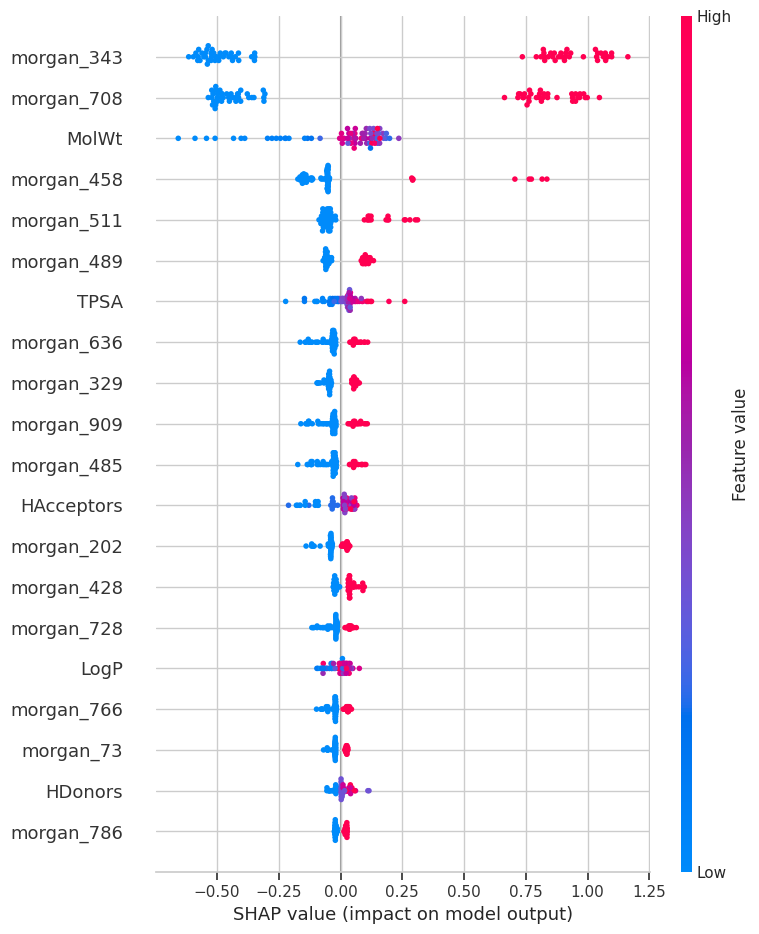

In [52]:
import shap

# TreeExplainer with Random Forest
explainer = shap.TreeExplainer(rf)  # rf = your trained RandomForestRegressor
shap_values = explainer.shap_values(X_test)

feature_names = [f"morgan_{i}" for i in range(1024)] + \
                ["MolWt","LogP","TPSA","HDonors","HAcceptors","RotBonds"]

shap.summary_plot(shap_values, X_test, feature_names=feature_names)